# Kaggle Competition: Ames Housing Dataset
# Notebook 3: Danielle Reycer

## Feature Engineering Exploration



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import stdev, mean

from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (cross_val_score, 
                                     train_test_split, 
                                     cross_validate, 
                                     KFold)

In [2]:
train = pd.read_csv('../datasets/train_clean1.csv')
test = pd.read_csv('../datasets/test_clean1.csv')

### Creating Features

In [3]:
train.isnull().sum().sort_values(ascending = False).head(11)

pool_qc          2040
misc_feature     1984
alley            1909
fence            1651
fireplace_qu      998
lot_frontage      330
garage_qual       113
garage_finish     113
garage_yr_blt     113
garage_cond       113
garage_type       113
dtype: int64

In [4]:
test.isnull().sum().sort_values(ascending=False).head(11)

pool_qc          874
misc_feature     837
alley            820
fence            706
fireplace_qu     422
lot_frontage     160
garage_yr_blt     45
garage_cond       45
garage_finish     45
garage_qual       45
garage_type       44
dtype: int64

In [5]:
# dropping some columns that have too many missing values
train.drop(['pool_qc', 'misc_feature', 'alley', 'fence', 'fireplace_qu'], axis=1, inplace=True)
test.drop(['pool_qc', 'misc_feature', 'alley', 'fence', 'fireplace_qu'], axis=1, inplace=True)

In [6]:
train.isnull().sum().sort_values(ascending=False).head(10)

lot_frontage      330
garage_finish     113
garage_cond       113
garage_yr_blt     113
garage_qual       113
garage_type       113
bsmt_exposure      57
bsmtfin_type_2     55
bsmt_cond          54
bsmt_qual          54
dtype: int64

In [7]:
test.isnull().sum().sort_values(ascending=False).head(20)

lot_frontage      160
garage_yr_blt      45
garage_cond        45
garage_finish      45
garage_qual        45
garage_type        44
bsmt_qual          25
bsmtfin_type_2     25
bsmt_cond          25
bsmt_exposure      25
bsmtfin_type_1     25
mas_vnr_type        1
electrical          1
mas_vnr_area        1
kitchen_abvgr       0
bedroom_abvgr       0
half_bath           0
full_bath           0
kitchen_qual        0
bsmt_full_bath      0
dtype: int64

Since there are so many lot frontage values in the data, I want to impute them based on something else other than the mean for the entire column. I will group by 'lot_shape' and impute with the mean for that category using a dictionary mapping.

In [8]:
shape_means = train.groupby('lot_shape')['lot_area'].mean()
shape_means

lot_shape
IR1    11478.713459
IR2    19995.454545
IR3    21102.222222
Reg     8815.518547
Name: lot_area, dtype: float64

In [9]:
shape_list = train.lot_shape.unique()
shape_list.sort()
shape_list

array(['IR1', 'IR2', 'IR3', 'Reg'], dtype=object)

In [10]:
lot_dict = {shape: mean for shape, mean in zip(shape_list, shape_means)}
print(lot_dict)

{'IR1': 11478.713458755426, 'IR2': 19995.454545454544, 'IR3': 21102.222222222223, 'Reg': 8815.51854714065}


In [11]:
train['lot_frontage'] = train['lot_frontage'].fillna(train['lot_shape'].apply(lambda x: lot_dict.get(x)))
test['lot_frontage'] = test['lot_frontage'].fillna(test['lot_shape'].apply(lambda x: lot_dict.get(x)))

In [12]:
# train.head(10)

test.isnull().sum().sort_values(ascending=False).head(20)

garage_yr_blt      45
garage_cond        45
garage_finish      45
garage_qual        45
garage_type        44
bsmtfin_type_2     25
bsmtfin_type_1     25
bsmt_exposure      25
bsmt_cond          25
bsmt_qual          25
mas_vnr_area        1
mas_vnr_type        1
electrical          1
open_porch_sf       0
wood_deck_sf        0
low_qual_fin_sf     0
gr_liv_area         0
bsmt_full_bath      0
bsmt_half_bath      0
full_bath           0
dtype: int64

In [13]:
# three_stdvs = mean(train['saleprice']) + (3 * stdev(train['saleprice']))
# train[train['saleprice'] > three_stdvs]

dropping these outliers to try and improve my model

In [14]:
train.shape

(2049, 80)

In [15]:
# source: https://www.geeksforgeeks.org/detect-and-remove-the-outliers-using-python/

# upper = np.where(train['saleprice'] >= three_stdvs)
# train.drop(upper[0], inplace=True)
# train.shape

In [16]:
# train.isnull().sum().sort_values(ascending=False).head(20)

In [17]:
train[train['bsmt_full_bath'].isna()]

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,lot_shape,land_contour,utilities,...,pool_area,misc_val,mo_sold,yr_sold,sale_type,saleprice,all_baths,huge_lot,recession,neighborhood_scl
616,1498,908154080,20,RL,123.0,47007,Pave,IR1,Lvl,AllPub,...,0,0,7,2008,WD,284700,NaN,1,1,1.304935


In [18]:
train.dropna(subset=['all_baths'], inplace=True)

In [19]:
train[train['bsmt_full_bath'].isna()]

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,lot_shape,land_contour,utilities,...,pool_area,misc_val,mo_sold,yr_sold,sale_type,saleprice,all_baths,huge_lot,recession,neighborhood_scl


### Dummying more columns

In [20]:
train['land_contour'].value_counts()

Lvl    1840
HLS      85
Bnk      80
Low      43
Name: land_contour, dtype: int64

In [21]:
train.land_contour.isnull().sum()

0

In [22]:
lc_dummies = pd.get_dummies(train['land_contour'])
lc_dummies_test = pd.get_dummies(test['land_contour'])
lc_dummies.isnull().sum()

Bnk    0
HLS    0
Low    0
Lvl    0
dtype: int64

In [23]:
train = pd.concat([train, lc_dummies], axis=1)
test = pd.concat([test, lc_dummies_test], axis=1)

In [24]:
test.isnull().sum().sort_values(ascending=False).head(20)

garage_qual       45
garage_cond       45
garage_yr_blt     45
garage_finish     45
garage_type       44
bsmt_cond         25
bsmt_qual         25
bsmtfin_type_2    25
bsmtfin_type_1    25
bsmt_exposure     25
mas_vnr_type       1
electrical         1
mas_vnr_area       1
fireplaces         0
id                 0
totrms_abvgrd      0
kitchen_qual       0
kitchen_abvgr      0
bedroom_abvgr      0
half_bath          0
dtype: int64

In [25]:
train.ms_zoning.value_counts()

RL         1597
RM          314
FV          101
C (all)      19
RH           14
A (agr)       2
I (all)       1
Name: ms_zoning, dtype: int64

In [26]:
train.ms_zoning.isnull().sum()

0

In [27]:
zoning_dummies = pd.get_dummies(train['ms_zoning'])
zoning_dummies_test = pd.get_dummies(test['ms_zoning'])


In [28]:
train = pd.concat([train, zoning_dummies], axis=1)
test = pd.concat([test, zoning_dummies_test], axis=1)


In [29]:
train.dropna(subset=['roof_style'], inplace=True)

In [30]:
roof_dummies = pd.get_dummies(train['roof_style'])
roof_dummies_test = pd.get_dummies(test['roof_style'])


In [31]:
train = pd.concat([train, roof_dummies], axis=1)
test = pd.concat([test, roof_dummies_test], axis=1)


In [32]:
train['overall_qual^2'] = (train['overall_qual']) ** 2
test['overall_qual^2'] = (test['overall_qual']) ** 2

In [33]:
# creating ordinal values for certain columns
# create the dictionary first

dict_list = train['heating_qc'].unique().tolist()
dict_list.sort()
quality_dict = {
    'Po': 1, 
    'Fa': 2, 
    'TA': 3, 
    'Gd': 4, 
    'Ex': 5
}

In [34]:
# creating new columns using dictionary for train and test data

train['kitchen_qual_ord'] = train['kitchen_qual'].apply(lambda x: quality_dict[x])
train['heating_qc_ord'] = train['heating_qc'].apply(lambda x: quality_dict[x])
train['exter_qual_ord'] = train['exter_qual'].apply(lambda x: quality_dict[x])

test['kitchen_qual_ord'] = test['kitchen_qual'].apply(lambda x: quality_dict[x])
test['heating_qc_ord'] = test['heating_qc'].apply(lambda x: quality_dict[x])
test['exter_qual_ord'] = test['exter_qual'].apply(lambda x: quality_dict[x])

### Modeling

My final interation of these features is below (iterated over several versions). 

In [35]:
features = ['ms_subclass', 'lot_area', 'overall_qual^2', 'overall_cond', 
            'year_built','bsmtfin_sf_1', 'total_bsmt_sf', '1st_flr_sf',  
            'gr_liv_area', 'bsmt_full_bath', 'totrms_abvgrd', 'fireplaces', 'garage_cars',
            'garage_area', 'wood_deck_sf', 'screen_porch', 'pool_area', 'misc_val',
            'neighborhood_scl', 'Bnk', 'HLS', 'kitchen_qual_ord', 'heating_qc_ord', 
            'exter_qual_ord']

len(features)

24

In [36]:
# setting up train_test_split
target = 'saleprice'

X = train[features]
y = train[target]


#train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                  test_size=0.2, 
                                                  random_state = 42)

# function to determine rmse
def find_rmse(model):
    y_true = y_val
    if model == LinearRegression:
        y_pred = lr.predict(X_val)
    elif model == LassoCV:
        y_pred = lasso_cv.predict(X_val_sc)
    elif model == RidgeCV:
        y_pred = ridge_cv.predict(X_val_sc)
    else:
        return "Cannot compute"
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [37]:
lr = LinearRegression(n_jobs= -1)
lr.fit(X_train, y_train)

scores = cross_val_score(lr, X_val, y_val)
lr.score(X_val, y_val), scores.mean(), lr.score(X_train, y_train)

(0.8808835798771789, 0.8781902584394828, 0.869323472520249)

In [38]:
# determining rmse
find_rmse(LinearRegression)

26137.645305440463

In [39]:
# export model to upload to Kaggle
X_test = test[features]

test['SalePrice'] = lr.predict(X_test)

export = test[['id', 'SalePrice']].copy()

export.rename(columns={'id':'Id'}, inplace=True)

export.to_csv('../attempts/attempt_16.csv', index = False)

In [40]:
# instantiate and fit standard scaler
ss = StandardScaler()
ss.fit(X_train)

# save the standardized values
X_train_sc = ss.transform(X_train)
X_val_sc = ss.transform(X_val)

# transform test data as well for exported file
X_test_sc = ss.transform(test[features])

In [41]:
# fit Lasso
lasso_cv = LassoCV(cv=10)
lasso_cv.fit(X_train_sc, y_train)

lasso_cv.score(X_val_sc, y_val), lasso_cv.score(X_train_sc, y_train)

(0.8801845975076573, 0.8672554059910753)

In [42]:
find_rmse(LassoCV)

26214.22177397624

The LassoCV model ended up being the best Kaggle Submission

In [43]:
# wanted a list of helpful features just in case I decided to try more things

# I ended up using the original list to pare down 'noisy' features
[(feature, coef) for (feature, coef) in zip(X.columns, lasso_cv.coef_)]

[('ms_subclass', -4700.563749104646),
 ('lot_area', 2484.3070370524047),
 ('overall_qual^2', 20123.433762032066),
 ('overall_cond', 3886.8525764151923),
 ('year_built', 2886.6612376685325),
 ('bsmtfin_sf_1', 6178.556891761865),
 ('total_bsmt_sf', 2475.286656788073),
 ('1st_flr_sf', 1921.653148091313),
 ('gr_liv_area', 16597.02677544592),
 ('bsmt_full_bath', 3325.1041888098953),
 ('totrms_abvgrd', 3139.1213351057813),
 ('fireplaces', 2870.1825745678766),
 ('garage_cars', 2604.1702725805935),
 ('garage_area', 2838.295093858292),
 ('wood_deck_sf', 1826.3062136335698),
 ('screen_porch', 3386.3265611246293),
 ('pool_area', -2094.8908241964655),
 ('misc_val', -4596.85741494744),
 ('neighborhood_scl', 17414.761292816085),
 ('Bnk', -1233.909099631672),
 ('HLS', 3230.5908570060806),
 ('kitchen_qual_ord', 6235.609842324327),
 ('heating_qc_ord', 772.418949143483),
 ('exter_qual_ord', 5860.971478334798)]

In [44]:
test['SalePrice'] = lasso_cv.predict(X_test_sc)

export = test[['id', 'SalePrice']].copy()

export.rename(columns={'id':'Id'}, inplace=True)

export.to_csv('../attempts/attempt_17.csv', index = False)

In [45]:
# instantiate and fit Ridge
ridge_cv = RidgeCV()
ridge_cv.fit(X_train_sc, y_train)

ridge_cv.score(X_val_sc, y_val)

0.8807387919584432

In [46]:
find_rmse(RidgeCV)

26153.525844641365

In [47]:
test['SalePrice'] = ridge_cv.predict(X_test_sc)

export = test[['id', 'SalePrice']].copy()

export.rename(columns={'id':'Id'}, inplace=True)

export.to_csv('../attempts/attempt_18.csv', index = False)

Since we only have 2051 data points, it would be ideal to drastically reduce the amount of features (my model currently has 24). Following a recommendation from fellow data scientist, Sophie Tabac, each feature requires around 400 data points. This would mean that we would want to limit our model to having around 5 or 6 features. The next section is my exploration of making the best possible model with far fewer features. 

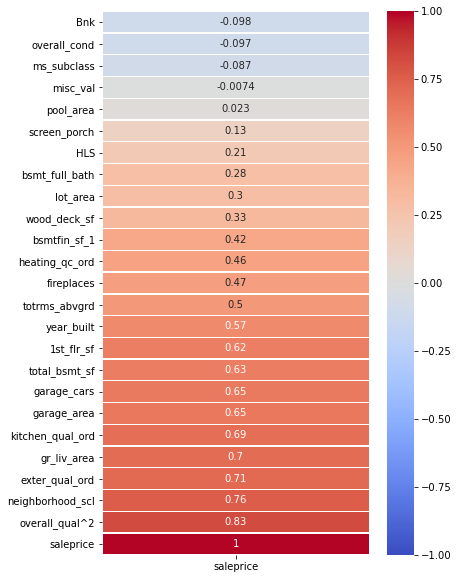

In [48]:
# started with most recent features list, and included sale price so I could use it to create a heatmap

features = ['ms_subclass', 'lot_area', 'overall_qual^2', 'overall_cond', 
            'year_built','bsmtfin_sf_1', 'total_bsmt_sf', '1st_flr_sf',  
            'gr_liv_area', 'bsmt_full_bath', 'totrms_abvgrd', 'fireplaces', 'garage_cars',
            'garage_area', 'wood_deck_sf', 'screen_porch', 'pool_area', 'misc_val',
            'neighborhood_scl', 'Bnk', 'HLS', 'kitchen_qual_ord', 'heating_qc_ord', 
            'exter_qual_ord', 'saleprice']

newdf = train[features]

plt.figure(figsize = (6, 10))
sns.heatmap(newdf.corr()[['saleprice']].sort_values('saleprice'), 
            annot = True, cmap = 'coolwarm', vmin = -1, vmax = 1, linewidths = 0.3);

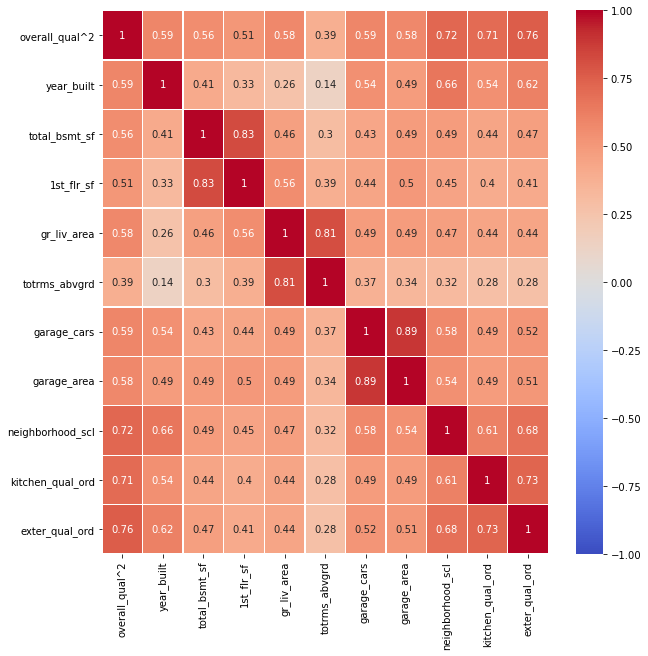

In [49]:
# cut down features to those with 0.5 correlation or better, 
# then looking for relationships between the features

features = ['overall_qual^2', 
            'year_built', 'total_bsmt_sf', '1st_flr_sf',  
            'gr_liv_area', 'totrms_abvgrd','garage_cars',
            'garage_area', 'neighborhood_scl', 'kitchen_qual_ord', 
            'exter_qual_ord']

newdf = train[features]

plt.figure(figsize=(10, 10))
sns.heatmap(newdf.corr(), 
            annot = True, 
            cmap = 'coolwarm', 
            vmin = -1, vmax = 1, 
            linewidths = 0.3);

In [50]:
features = ['overall_qual^2', 
            'year_built', 'total_bsmt_sf', '1st_flr_sf',  
            'gr_liv_area',
            'garage_area', 'neighborhood_scl', 'kitchen_qual_ord']

In [51]:
# setting up train_test_split
target = 'saleprice'

X = train[features]
y = train[target]


#train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                  test_size=0.2, 
                                                  random_state = 42)


In [52]:
lr = LinearRegression(n_jobs= -1)
lr.fit(X_train, y_train)

scores = cross_val_score(lr, X_val, y_val)
lr.score(X_val, y_val), scores.mean()

(0.8396729836574462, 0.8462934547878987)

In [53]:
find_rmse(LinearRegression)

30323.826212968273

In [60]:
[(feature, coef) for (feature, coef) in zip(features, lr.coef_)]

[('overall_qual^2', 1196.8055340490816),
 ('year_built', 51.25194999312665),
 ('total_bsmt_sf', 15.344559866401898),
 ('1st_flr_sf', 9.757579195817009),
 ('gr_liv_area', 37.95594425647616),
 ('garage_area', 34.61942451364714),
 ('neighborhood_scl', 34210.62307195563),
 ('kitchen_qual_ord', 14541.46909385068)]

In [54]:
# instantiate and fit standard scaler
ss = StandardScaler()
ss.fit(X_train)

# save the standardized values
X_train_sc = ss.transform(X_train)
X_val_sc = ss.transform(X_val)

# transform test data as well for exported file
X_test_sc = ss.transform(test[features])

In [55]:
# fit Lasso
lasso_cv = LassoCV(cv=10)
lasso_cv.fit(X_train_sc, y_train)

lasso_cv.score(X_val_sc, y_val), lasso_cv.score(X_train_sc, y_train)

(0.8393015811699933, 0.8294157599488876)

In [56]:
find_rmse(LassoCV)

30358.928935805798

In [57]:
# instantiate and fit Ridge
ridge_cv = RidgeCV()
ridge_cv.fit(X_train_sc, y_train)

ridge_cv.score(X_val_sc, y_val), lasso_cv.score(X_train_sc, y_train)

(0.839793138295182, 0.8294157599488876)

In [58]:
find_rmse(RidgeCV)

30312.461218649558